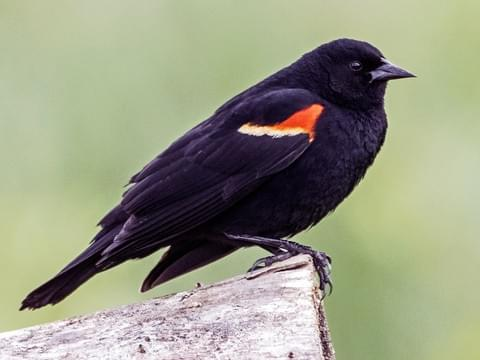

# Overview
Let's look at the "secondary labels" provided in train.csv. These secondary labels describe other birds also heard in the clip, apart from the target "primary" label. Hopefully this notebook can help us understand what these secondary labels are and how to handle them.

TLDR: 202/264 species have overlap between secondary and primary labels. i.e. suppose some audio clip has label 'aldfly', representing the alder flycatcher. Some other audio for a different bird might have alder flycatcher as a secondary label - this occurs in 202 of the target species. See below for more details + implications.

PS - I'm still kinda new here, so any thoughts/advice would be appreciated!

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import soundfile as sf
import librosa
import IPython
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/kaggle/input/birdsong-recognition/train.csv')
df['path'] = '/kaggle/input/birdsong-recognition/train_audio/'+df['ebird_code']+'/'+df['filename']

In [ ]:
df['secondary'] = df['secondary_labels'].str.replace(r"\[|\]|\'|\"","").str.split('\,').apply(lambda x: [i.strip() for i in x])
secondary_labels = [item.strip() for sublist in df['secondary'].tolist() for item in sublist if item != '']
secondary_labels = pd.Series(secondary_labels, name='secondary_labels')

# Let's look at summary statistics for the secondary labels

In [ ]:
print("Describe")
print(secondary_labels.describe())

print("\n10 most commonly heard secondary birds")
print(secondary_labels.groupby(by=secondary_labels).count().nlargest(10))

print("\n10 least commonly heard secondary birds")
print(secondary_labels.groupby(by=secondary_labels).count().nsmallest(10))

secondary_labels.groupby(by=secondary_labels).count().hist(bins=10);

First, we notice that there are A LOT of secondary labels - 21259 of them. Amongst those labels, there is quite an imbalance here - some birds appear quite often as secondary labels, but a large number of birds only appear once. Next, we see how many of these secondary labels are also "primary" labels in the dataset

In [ ]:
species = df['species'].unique()
secondary_species = [arr[1] for arr in secondary_labels.str.split('_').tolist()]
intersection = [s for s in species if s in secondary_species] 

In [ ]:
len(intersection)

There are 202 species which are in both the train set and are secondary labels! WOW. Keep in mind there are only 264 species we are tasked with predicting! Let's see how many additional secondary labels there are which also belong to species which appear as targets.

In [ ]:
def count_intersection(species, arr):
    count = 0
    for s in species:
        if s != '' and s.split("_")[1] in arr:
            count +=1
    return count

In [ ]:
additional_examples = df[df['secondary'].apply(lambda x: count_intersection(x, intersection) > 0)]['secondary'].tolist()
additional_examples = [s for sublist in additional_examples for s in sublist if s.split("_")[1] in intersection]
additional_examples = pd.Series(additional_examples)

In [ ]:
print("Count of secondary labels within examples that are also primary targets")
print(additional_examples.describe())

print("\n10 most common additional examples")
print(additional_examples.groupby(by=additional_examples).count().nlargest(10))

print("\n10 least common additional examples")
print(additional_examples.groupby(by=additional_examples).count().nsmallest(10))

additional_examples.groupby(by=additional_examples).count().hist(bins=10);

So there are 13786 secondary labels which also belong to primary targets. In other words, we have 13786 additional unlabeled examples which we could train on, hidden somewhere within the audio we already have... You'll also notice that of the top 10 secondary labels, only one of them, the white-winged dove, is not a target

# Let's look at the red-winged blackbird in more detail
First, we look at what other birds the red-winged blackbird is commonly featured with.

In [ ]:
def filter_secondary(arr, species):
    for bird in arr:
        if bird != '' and bird.split("_")[1] == species:
            return True
    return False

In [ ]:
rewbla = df[df['secondary'].apply(lambda x: filter_secondary(x, 'Red-winged Blackbird'))]
rewbla['ebird_code'].describe()
rewbla['ebird_code'].groupby(by=rewbla['ebird_code']).count().nlargest(10)

It looks like the red-winged blackbird and Wilson's snipe commonly are heard together. Let's play one of the overlapping clips and see if we can hear the red-winged blackbird within it. First, this is what a red winged blackbird sounds like

In [ ]:
rewbla_audio, sr = librosa.load('../input/birdsong-recognition/train_audio/rewbla/XC135672.mp3', sr=32000);
IPython.display.Audio(rewbla_audio, rate=sr)

Compare that to a snippet with a label of Wilson's Snipe below - notice that faintly, around the 1-2 second mark you can hear the sound from the red-winged-blackbird.

In [ ]:
wilsni1_audio, sr = librosa.load('../input/birdsong-recognition/train_audio/wilsni1/XC185863.mp3', sr=32000);
wilsni1_audio = wilsni1_audio[17*sr:22*sr]
IPython.display.Audio(wilsni1_audio, rate=sr)

Let's visualize the mel spectrogram side by side and see if we notice anything.

In [ ]:
melspectrogram_parameters = {
    "n_mels": 128,
    "fmin": 20,
    "fmax": 16000
}
rewbla_melspec = librosa.feature.melspectrogram(rewbla_audio, sr=32000, **melspectrogram_parameters)
rewbla_melspec = librosa.power_to_db(rewbla_melspec).astype(np.float32)

wilsni1_melspec = librosa.feature.melspectrogram(wilsni1_audio, sr=32000, **melspectrogram_parameters)
wilsni1_melspec = librosa.power_to_db(wilsni1_melspec).astype(np.float32)

fig=plt.figure(figsize=(16, 8))
fig.add_subplot(1, 2, 1).set_title("Red-winged Blackbird")
plt.imshow(rewbla_melspec)
fig.add_subplot(1, 2, 2).set_title("Wilson's Snipe")
plt.imshow(wilsni1_melspec)
plt.show()

It's difficult to tell the presence of the red-winged blackbird visually - around t=50-100, there are some shadows that look similar to the red-winged blackbird's call

Next, let's look at geographic correlation - where are the red-winged blackbird recording's made, compared to recordings for birds it co-occurs with?

In [ ]:
rewbla=rewbla[rewbla.latitude!='Not specified']
fig = go.Figure()
fig.add_trace(go.Scattergeo(
        lon = rewbla['longitude'],
        lat = rewbla['latitude'],
        text = rewbla['ebird_code'],
        name='Co-occuring Locations',
        marker = dict(
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area',
        )))


fig.add_trace(go.Scattergeo(
        lon = df[df['ebird_code'] == 'rewbla']['longitude'],
        lat = df[df['ebird_code'] == 'rewbla']['latitude'],
        text = df[df['ebird_code'] == 'rewbla']['ebird_code'],
        name='Red-winged Blackbird Locations',
        marker = dict(
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area',
        )))

fig.update_layout(
        title_text = 'Geographical Correlation between Red-winged Blackbird and co-occuring species',
        showlegend = True,
        geo = dict(
            landcolor = 'rgb(217, 217, 217)',
            scope="north america",
        )
    )

fig.show()

# Now what?

Let's take a minute to debrief. We are trying to predict 264 species. 202/264 of those species have additional occurences in the train set as secondary labels. We now have three main choices as I see it.

* Keep all secondary labels separate and still only predict primary targets
     * Here, we wonder if this might cause our model too much confusion. It could identify a bird call correctly (since it is present, as a secondary label), but loss would only be computed against the primary labels.
* Treat secondary labels as primary labels when predicting each clip
     * This could be tricky. What we want to know is, within a given clip of train audio, how often does each secondary label appear? IF this is high, we could use the "secondary label" as a primary label for that clip, since it occurs frequently enough we're likely to catch it within some sample. If it's frequency is low, however, and the clip is long, then if we take a random sample from the clip, chances are it won't contain the secondary label - thus, it wouldn't be good to use it as a prediction target.
* Include secondary labels but give secondary labels a different weight for target prediction
    * This seems like a good option - it is a sort of combination between the first two, and helps give the model some recognition for the hard work it's doing predicting those secondary labels. Of course, we have the same concern as in option 2, so we still need to think carefully
    
One last thing to think about is the test set we are scored against. Will a label that is considered a "secondary label" in the train audio  be treated as more of a "primary" label in the test audio? My hunch is yes, given the example_test_audio - there are many bird calls which appear within the sample 5 second interval in the test example, suggesting some of these "secondary" labels will be required to be predicted.

# To be continued
For next steps, we may want to figure out the frequency of secondary labels within audio samples which have a different primary target. This can help us decide between the three options above.

In the meantime, below is a python dict which contains secondary ebird codes to experiment around with! It is indexed by file name, for example 'XC134874.mp3'

In [ ]:
ebird_dict = {}
for bird in intersection:
    ebird_dict[bird] = df[df['species'] == bird]['ebird_code'].iloc[0]

In [ ]:
secondary_dict = {}
for index, row in df.iterrows():
    s = [ebird_dict[bird.split("_")[1]] for bird in row['secondary'] if bird != "" and bird.split("_")[1] in ebird_dict]
    secondary_dict[row['filename']] = s

In [ ]:
import pickle
with open('secondary_ebird.pkl', 'wb') as f:
    pickle.dump(secondary_dict, f)

In [ ]:
# to load it, use the following snippet
# secondary_dict = {}
# with open(PATH, 'rb') as f:
#     secondary_dict = pickle.load(f)